# The fonctions to import


In [9]:
import numpy as np
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('deep')



# The scraping of the funds of french private company's

In [10]:


def scrape_french_funds():
    url = 'https://www.investing.com/funds/france-funds'
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')

        Name = []
        Symbol = []
        Last = []
        Chg = []
        Total_Assets = []
        Time = []

        table = soup.find('table')
        if table:
            rows = table.find_all('tr')[1:]  
            for row in rows:
                cols = row.find_all('td')
                # print(f"Columns in row: {[col.text.strip() for col in cols]}") # DEBUG PRINT: Show column contents
                if len(cols) >= 8:  
                    Name.append(cols[1].text.strip())  
                    Symbol.append(cols[2].text.strip()) 
                    Last.append(cols[3].text.strip())   
                    Total_Assets.append(cols[5].text.strip()) 
                    Time.append(cols[6].text.strip())   
                    try:
                        Chg_value = float(cols[4].text.strip().replace('%', '')) 
                        Chg.append(Chg_value)
                    except ValueError:
                        Chg.append(None)
                        print(f"Warning: Could not convert '{cols[4].text.strip()}' to float for 'Chg'")

        # Create DataFrame
        df = pd.DataFrame({
            'Name': Name,
            'Symbol': Symbol,
            'Last': Last,
            'Chg': Chg,
            'Total_Assets': Total_Assets,
            'Time': Time
            })

        return df

    except Exception as e:
        print(f'Error scraping data: {e}')
        return None

df = scrape_french_funds()
print(df)

                                         Name   Symbol         Last   Chg  \
0              Amundi Euro Liquidity SRI IC C  0P0000.  249,580.888  0.01   
1              Carmignac Patrimoine A EUR Acc  0P0000.      714.130  0.37   
2             Carmignac Patrimoine A EUR Ydis  0P0000.      116.740  0.37   
3              Carmignac Patrimoine E EUR Acc  0P0000.      171.680  0.37   
4          Carmignac Patrimoine A CHF Acc Hdg  0P0000.      115.060  0.37   
..                                        ...      ...          ...   ...   
95                               ALM Offensif  0P0000.      310.300 -1.26   
96              29 Haussmann Euro Rendement C  0P0000.    1,607.860  0.10   
97  Candriam Index Arbitrage Classique en EUR  0P0000.    1,520.190  0.12   
98          BNP Paribas Actions Monde Classic  0P0000.       31.120 -0.16   
99   Natixis Ultra Short Term Bonds Plus SI C  0P0000.    1,711.910  0.01   

   Total_Assets   Time  
0        53.84B  13/03  
1         6.07B  12/03  


# Fetch the data


In [11]:
funds_df = scrape_french_funds()

if funds_df is not None:
    print('French Companies Funds Data:')
    display(funds_df)

French Companies Funds Data:


,Name,Symbol,Last,Chg,Total_Assets,Time
0,Amundi Euro Liquidity SRI IC C,0P0000.,"249,580.888",0.01,54.45B,13/03
1,Carmignac Patrimoine A EUR Acc,0P0000.,714.130,0.37,6.07B,12/03
2,Carmignac Patrimoine A EUR Ydis,0P0000.,116.740,0.37,6.07B,12/03
3,Carmignac Patrimoine E EUR Acc,0P0000.,171.680,0.37,6.07B,12/03
4,Carmignac Patrimoine A CHF Acc Hdg,0P0000.,115.060,0.37,6.07B,12/03
...,...,...,...,...,...,...
95,ALM Offensif,0P0000.,310.300,-1.26,1.12B,11/03
96,29 Haussmann Euro Rendement C,0P0000.,"1,607.860",0.10,1.3B,12/03
97,Candriam Index Arbitrage Classique en EUR,0P0000.,"1,520.190",0.12,256.67M,12/03
98,BNP Paribas Actions Monde Classic,0P0000.,31.120,-0.16,1.36B,12/03


# Risk Analysis

In [12]:
funds_df['Risk'] = funds_df['Chg'].abs()
sorted_df = funds_df.sort_values(by='Risk', ascending=True)

print("Funds from Lowest to Highest Risk:")
display(sorted_df[['Name', 'Risk', 'Total_Assets', 'Chg']])

Funds from Lowest to Highest Risk:


,Name,Risk,Total_Assets,Chg
0,Amundi Euro Liquidity SRI IC C,0.01,54.45B,0.01
10,Groupama Trésorerie M,0.01,7.75B,0.01
13,Groupama Entreprises R,0.01,6.25B,0.01
14,Groupama Entreprises N,0.01,6.26B,0.01
12,Groupama Entreprises IC,0.01,6.25B,0.01
...,...,...,...,...
59,Oddo Avenir Europe DR-EUR,1.17,1.25B,1.17
60,Oddo Avenir Europe CI-EUR,1.17,1.25B,1.17
57,Oddo Avenir Europe CN-EUR,1.17,1.25B,1.17
95,ALM Offensif,1.26,1.12B,-1.26


In [13]:
# En yüksek getiriye sahip ilk 5 fon
top5_getiri = funds_df.sort_values(by='Chg', ascending=False).head(5)[['Name', 'Chg']]

print("🏆 En İyi Performans Gösteren İlk 5 Fon (Değişim Oranına Göre):")
print(top5_getiri.to_string(index=False))

🏆 En İyi Performans Gösteren İlk 5 Fon (Değişim Oranına Göre):
                                        Name  Chg
Ofi Financial Investment - Precious Metals R 1.26
                   Oddo Avenir Europe CN-EUR 1.17
                   Oddo Avenir Europe CI-EUR 1.17
                   Oddo Avenir Europe DR-EUR 1.17
                   Oddo Avenir Europe CR-EUR 1.17


In [14]:
# En düşük riskli ilk 5 fon
top5_dusuk_risk = funds_df.sort_values(by='Risk', ascending=True).head(5)[['Name', 'Risk']]

print("\n🛡️ En Az Riskli İlk 5 Fon:")
print(top5_dusuk_risk.to_string(index=False))


🛡️ En Az Riskli İlk 5 Fon:
                          Name  Risk
Amundi Euro Liquidity SRI IC C  0.01
         Groupama Trésorerie M  0.01
        Groupama Entreprises R  0.01
        Groupama Entreprises N  0.01
       Groupama Entreprises IC  0.01


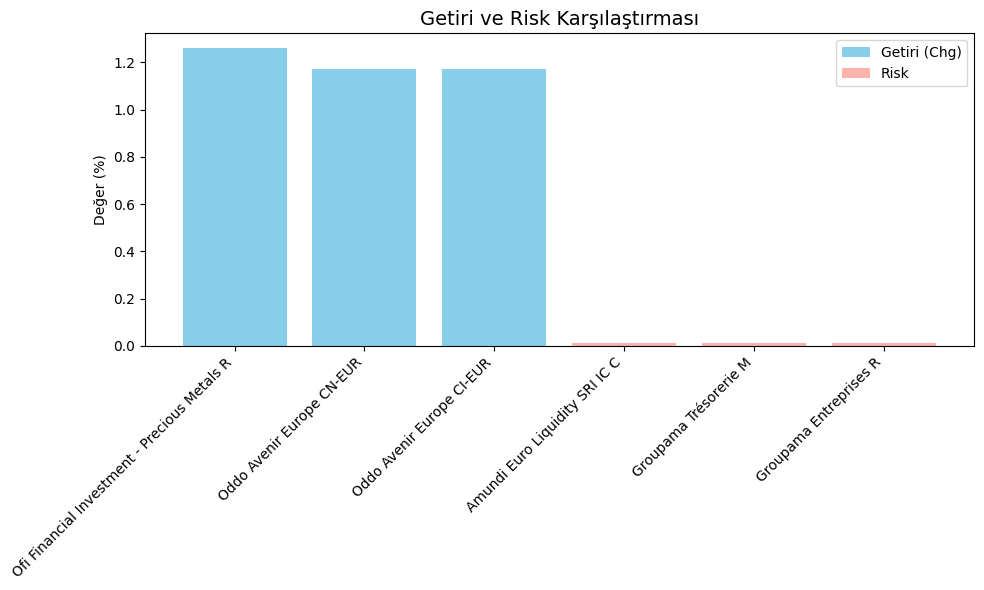

NameError: name 'corr_matrix' is not defined

In [18]:
import matplotlib.pyplot as plt

# En iyi 3 getiri ve en düşük 3 riskli fonları seç
best_3 = top5_getiri.head(3)
safe_3 = top5_dusuk_risk.head(3)
combined_df = pd.concat([best_3, safe_3], axis=0)

# Getiri-Risk Karşılaştırma Grafiği
plt.figure(figsize=(10, 6))
plt.bar(combined_df['Name'], combined_df['Chg'], color='skyblue', label='Getiri (Chg)')
plt.bar(combined_df['Name'], combined_df['Risk'], color='salmon', alpha=0.6, label='Risk')
plt.title('Getiri ve Risk Karşılaştırması', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Değer (%)')
plt.legend()
plt.tight_layout()
plt.show()

# Korelasyon Analizi
print(f"\n🔍 'Chg' ve 'Risk' Arasındaki Korelasyon: {corr_matrix.loc['Chg', 'Risk']:.2f}")
print("Yorum: Pozitif korelasyon, yüksek getirinin genellikle daha yüksek riskle ilişkili olduğunu gösteriyor.")

In [16]:
print("\n### Hücre 4: Portföy Önerileri ###")

# Düşük Risk
low_risk_portfolio = funds_df.sort_values(by='Risk').head(3)[['Name', 'Risk']]
print("\n**Düşük Risk Toleransı İçin:**")
print(low_risk_portfolio[['Name']].to_string(index=False, header=False))

# Orta Risk
median_risk = funds_df['Risk'].median()
medium_risk_portfolio = funds_df[(funds_df['Risk'] > median_risk * 0.5) & 
                                 (funds_df['Risk'] < median_risk * 1.5) & 
                                 (funds_df['Chg'] > 0)].head(3)[['Name', 'Risk', 'Chg']]
print("\n**Orta Risk Toleransı İçin:**")
print(medium_risk_portfolio[['Name']].to_string(index=False, header=False))

# Yüksek Risk
high_risk_portfolio = funds_df.sort_values(by='Chg', ascending=False).head(3)[['Name', 'Chg', 'Risk']]
print("\n**Yüksek Risk Toleransı İçin:**")
print(high_risk_portfolio[['Name']].to_string(index=False, header=False))


### Hücre 4: Portföy Önerileri ###

**Düşük Risk Toleransı İçin:**
Amundi Euro Liquidity SRI IC C
         Groupama Trésorerie M
        Groupama Entreprises R

**Orta Risk Toleransı İçin:**
 Carmignac Patrimoine A EUR Acc
Carmignac Patrimoine A EUR Ydis
 Carmignac Patrimoine E EUR Acc

**Yüksek Risk Toleransı İçin:**
Ofi Financial Investment - Precious Metals R
                   Oddo Avenir Europe CN-EUR
                   Oddo Avenir Europe CI-EUR
